# Bayesian Networks
**COMP9418-20T3, W03 Tutorial**

- Instructor: Gustavo Batista
- School of Computer Science and Engineering, UNSW Sydney
- Questions adapted by Gustavo Batista from a Jupyter notebook developed by Daniel Mackinlay and Edwin V. Bonilla
- Last Update 24th Setember at 18:00, 2020
$$
% macros
\newcommand{\indep}{\perp \!\!\!\perp}
$$

In this week's tutorial, we will start exploring representation and inference with Bayesian networks.

## Technical prerequisites

You will need certain packages installed to run this notebook.

If you are using ``conda``'s default
[full installation](https://conda.io/docs/install/full.html),
these requirements should all be satisfied already.

If you are using ``virtualenv`` or other native package management,
you may need to run this command:

```python
pip3 install pandas
```

To render a visualization of some graphical models, you also need to install Graphviz [download page](http://www.graphviz.org/download). We have already used this library in Tutorial 1, thus, you should have it installed. If you do not have it and use the conda installation, then use the command ```conda install python-graphviz```. 

You will also need to download the preprocessed `icu_diag.csv` data set (see data file for this tutorial in WebCMS3) and put it in the same folder as this notebook.

Once we have done all that, we import some useful modules for later use.

In [1]:
# Make division default to floating-point, saving confusion
from __future__ import division
from __future__ import print_function

# Necessary libraries
import numpy as np
import pandas as pd

# combinatorics
from itertools import product, combinations
# ordered dictionaries are useful for keeping ordered sets of varibles
from collections import OrderedDict as odict
#visualise our graph
from graphviz import Digraph

# table formating for screen output
from tabulate import tabulate

# easier debugging display
pd.set_option('display.multi_sparse', False)
from pprint import pprint

In this tutorial, we will need the `printFactor` and `prob` functions defined in the previous tutorial.

In [2]:
def printFactor(f):
    """
    argument 
    `f`, a factor to print on screen
    """
    # Create a empty list that we will fill in with the probability table entries
    table = list()
    
    # Iterate over all keys and probability values in the table
    for key, item in f['table'].items():
        # Convert the tuple to a list to be able to manipulate it
        k = list(key)
        # Append the probability value to the list with key values
        k.append(item)
        # Append an entire row to the table
        table.append(k)
    # dom is used as table header. We need it converted to list
    dom = list(f['dom'])
    # Append a 'Pr' to indicate the probabity column
    dom.append('Pr')
    print(tabulate(table,headers=dom,tablefmt='orgtbl'))
    
def prob(factor, *entry):
    """
    argument 
    `factor`, a dictionary of domain and probability values,
    `entry`, a list of values, one for each variable in the same order as specified in the factor domain.
    
    Returns p(entry)
    """

    return factor['table'][entry]     # insert your code here, 1 line    


## `pandas`

We will be using an external library for the loading tabular data: `pandas.DataFrame` is somewhat similar to `R`. 
If you wish to know more about that, [check out the Pandas intro](https://pandas.pydata.org/pandas-docs/stable/user_guide/10min.html). We will mostly be ignoring this library, except to load data and display it in nice tables.



# The Data

## Loading the data

These data correspond to the problem in the theory part of the tutorial for this week, i.e. the Bayesian network for medical diagnosis in an intensive care unit (ICU). The data are in `csv` format.
We can load this in several ways in python, but the most convenient for this purpose 
is to load it as a `DataFrame` in `pandas`.

In [3]:
data = pd.read_csv(open('icu_diag.csv'))

The loaded data frame is an attribute-value table. It contais 1000 rows (examples), each one correponding to a patient in the intensive care unit. Each row has nine colums (attributes). Each column correponds to one variable in the Bayesian network. The next figure illustrates the network.

![ICU Graph](img/ICU_graph.png "Graph exercise")

We can use the command ``data.head()`` to display the first $n$ rows (default = 5) of the data frame.

In [4]:
data.head()

,A,C,B,H,L,O,S,T,V
0,0,0,1,1,0,0,1,1,0
1,0,1,2,0,0,2,1,1,1
2,0,2,2,0,0,2,1,1,1
3,0,2,0,0,0,2,1,0,1
4,0,1,2,0,0,2,1,1,1


The values in the cariables are encoded as follows:

| Variable  |  Value  |  Coding |
| :-------: | :-----: | ------: |
| H, L, A   |  False  | 0       |
| H, L, A   |  True   | 1       |
| V, S, T   |  Low    | 0       |
| V, S, T   |  High   | 1       |
| C, O, B   |  Low    | 0       |
| C, O, B   |  Medium | 1       |
| C, O, B   |  High   | 2       |

For now, we will keep this encoding as provided in the data file. However, replacing the numerical codes by symbolic labels may improve the results readability. To keep this notebook short, we will leave this extension as an exercise.

# Estimating the probability tables from the data

We need to estimate a discrete distribution
for each (conditional) probability distribution.

### Exercise

Let's first represent this graph using the adjacency list discussed in the tutorial 01. We created a stub for you.

In [20]:
graph = {                 # ICU graph adjacency list. 9 lines
}

In [5]:
# Answer

graph = {
    'L': ['S', 'V'],
    'H': ['S', 'V'],
    'S': ['O'],
    'V': ['C', 'O'],
    'O': ['B'],
    'A': ['T'],
    'T': ['B'],
    'C': [],
    'B': [],
}

Let's use GraphViz to display the graph representation, so we can assure we did not forget any edges

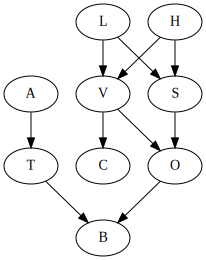

In [6]:
dot = Digraph(comment='ICU Graph')

for v in graph:
    dot.node(str(v))

for v in graph:
    for w in graph[v]:
        dot.edge(str(v), str(w))
dot

We also need to declare a data structure with the possible outcomes for each variable.

In [7]:
# possible outcomes, by variable
outcomeSpace = dict(
    H=(0,1),
    L=(0,1),
    A=(0,1),
    V=(0,1),
    S=(0,1),
    T=(0,1),
    C=(0,1,2),
    O=(0,1,2),
    B=(0,1,2),
)

Now we estimate parameters by constructing conditional distributions for each node in our graph.
We will take the proportions of empirical counts as estimates of the probabilities of the counted outcomes, i.e.
$$
\hat{p}(\boldsymbol{X_i}=\boldsymbol{x},\boldsymbol{Y_i}=\boldsymbol{y})=\frac{N_{\boldsymbol{x}, \boldsymbol{y}}}{N},
$$
and
$$
\hat{p}(\boldsymbol{X_i}=\boldsymbol{x}\mid\boldsymbol{Y_i}=\boldsymbol{y})=\frac{N_{\boldsymbol{x}, \boldsymbol{y}}}{N_\boldsymbol{y}},
$$

where $N_{\boldsymbol{x}, \boldsymbol{y}}$ is the number of observations of that outcome,
$$N_{\boldsymbol{x}, \boldsymbol{y}}:=\sum_i\boldsymbol{X_i}=\boldsymbol{x}\cap\boldsymbol{Y_i}=\boldsymbol{y},$$ and $N$ is the total number of observations.

Later, we will see this procedure of estimating parameters corresponds to the Maximum Likelihood Estimate (MLE).

Below is another helper function. This will calculate joint occurrence probability tables.
you invoke it like this
```
prob_table = est_prob_table(data, 'V', ['H', 'L'])
```
to estimate all conditional occurrence probabilities of $V|H,L$.

In [8]:
def allEqualThisIndex(dict_of_arrays, **fixed_vars):
    """
    Helper function to create a boolean index vector into a tabular data structure,
    such that we return True only for rows of the table where, e.g.
    column_a=fixed_vars['column_a'] and column_b=fixed_vars['column_b'].
    
    This is a simple task, but it's not *quite* obvious
    for various obscure technical reasons.
    
    It is perhaps best explained by an example.
    
    >>> all_equal_this_index(
    ...    {'X': [1, 1, 0], Y: [1, 0, 1]},
    ...    X=1,
    ...    Y=1
    ... )
    [True, False, False]
    """
    # base index is a boolean vector, everywhere true
    first_array = dict_of_arrays[list(dict_of_arrays.keys())[0]]
    index = np.ones_like(first_array, dtype=np.bool_)
    for var_name, var_val in fixed_vars.items():
        index = index & (np.asarray(dict_of_arrays[var_name])==var_val)
    return index

def estProbTable(data, var_name, parent_names, outcomeSpace):
    """
    Calculate a dictionary probability table by ML given
    `data`, a dictionary or dataframe of observations
    `var_name`, the column of the data to be used for the conditioned variable and
    `parent_names`, a tuple of columns to be used for the parents and
    `outcomeSpace`, a dict that maps variable names to a tuple of possible outcomes
    Return a dictionary containing an estimated conditional probability table.
    """    
    var_outcomes = outcomeSpace[var_name]
    parent_outcomes = [outcomeSpace[var] for var in (parent_names)]
    # cartesian product to generate a table of all possible outcomes
    all_parent_combinations = product(*parent_outcomes)

    prob_table = odict()
    
    for i, parent_combination in enumerate(all_parent_combinations):
        parent_vars = dict(zip(parent_names, parent_combination))
        parent_index = allEqualThisIndex(data, **parent_vars)
        for var_outcome in var_outcomes:
            var_index = (np.asarray(data[var_name])==var_outcome)
            prob_table[tuple(list(parent_combination)+[var_outcome])] = (var_index & parent_index).sum()/parent_index.sum()
            
    return {'dom': tuple(list(parent_names)+[var_name]), 'table': prob_table}


##############################
# Test code
##############################
printFactor(estProbTable(data, 'V', ['H', 'L'], outcomeSpace))

|   H |   L |   V |        Pr |
|-----+-----+-----+-----------|
|   0 |   0 |   0 | 0.0447958 |
|   0 |   0 |   1 | 0.955204  |
|   0 |   1 |   0 | 0         |
|   0 |   1 |   1 | 1         |
|   1 |   0 |   0 | 0.994764  |
|   1 |   0 |   1 | 0.0052356 |
|   1 |   1 |   0 | 1         |
|   1 |   1 |   1 | 0         |


Now, we will use the above function to calculate the probability tables for all 9 variables of the ICU Bayesian Network. 

However, notice that the `estProbTable(data, var_name, parent_names, outcomeSpace)` requires the variable name (`var_name`) and the parent names (`parent_names`). We do not have this information readly available. The adjacency list provides the children of each node, not its parents.

The question is, how can be invert the graph data structure so that each node will point to its parents? Yes, the answer is the graph transpose operation, reviwed in Tutorial 01.

We implemented this function for you.

In [9]:
def transposeGraph(G):
    GT = dict((v, []) for v in G)
    for v in G:
        for w in G[v]:
            GT[w].append(v)

    return GT

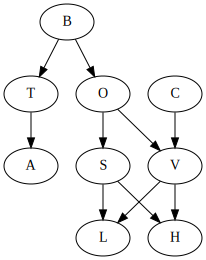

In [10]:
graphT = transposeGraph(graph)

dot = Digraph(comment='Direct transpose graph GT')

for v in graphT:
    dot.node(str(v))

for v in graphT:
    for w in graphT[v]:
        dot.edge(str(v), str(w))
dot

### Exercise

Use the `estProbTable(data, var_name, parent_names, outcomeSpace)` function to calculate probability tables for all 9 variables in our DAG (Bayesian network structure in the theory part of the tutorial). Store them in a dictionary called `cond_tables_ml`.

In [11]:
cond_tables_ml = odict()
for node, parents in graphT.items():
    cond_tables_ml[node] = None             # Estimate the probability for a single table. 1 line

##############################
# Test code
##############################
print('estimated P(H)=')
pprint(dict(cond_tables_ml['H']))
print()
print('estimated P(V|H,L)=')
pprint(dict(cond_tables_ml['V']))

estimated P(H)=


TypeError: 'NoneType' object is not iterable

In [12]:
# Answer

cond_tables_ml = odict()
for node, parents in graphT.items():
    cond_tables_ml[node] = estProbTable(         # Estimate the probability for a single table. 1 line
        data,
        node,
        parents,
        outcomeSpace)

##############################
# Test code
##############################
print('estimated P(H)=')
printFactor(cond_tables_ml['H'])
print()
print('estimated P(V|H,L)=')
printFactor(cond_tables_ml['V'])

estimated P(H)=
|   H |    Pr |
|-----+-------|
|   0 | 0.801 |
|   1 | 0.199 |

estimated P(V|H,L)=
|   L |   H |   V |        Pr |
|-----+-----+-----+-----------|
|   0 |   0 |   0 | 0.0447958 |
|   0 |   0 |   1 | 0.955204  |
|   0 |   1 |   0 | 0.994764  |
|   0 |   1 |   1 | 0.0052356 |
|   1 |   0 |   0 | 0         |
|   1 |   0 |   1 | 1         |
|   1 |   1 |   0 | 1         |
|   1 |   1 |   1 | 0         |


If you implemented this code correctly, you should see an output like this:
    
```
estimated P(H)=
|   H |    Pr |
|-----+-------|
|   0 | 0.801 |
|   1 | 0.199 |


estimated P(V|H,L)=
|   L |   H |   V |        Pr |
|-----+-----+-----+-----------|
|   0 |   0 |   0 | 0.0447958 |
|   0 |   0 |   1 | 0.955204  |
|   0 |   1 |   0 | 0.994764  |
|   0 |   1 |   1 | 0.0052356 |
|   1 |   0 |   0 | 0         |
|   1 |   0 |   1 | 1         |
|   1 |   1 |   0 | 1         |
|   1 |   1 |   1 | 0         |
```

# Conditional probabilities by naïve summation

We are interested in calculating the conditional distributions.
For the moment we will attempt to find the conditional distribution
$p(L\mid C=\text{high})$.

We will compute $p(L\mid C=\text{high})$ by naïve summation.

To do this, we will need to reconstruct each of the joint probabilities from our graph.
Remember that we know that we know a factorization for the joint probabilities,
specifically,

$$p(B,T,O,C,V,S,H,L,A)=p(B\mid O,T)p(T\mid A)p(O\mid V,S)p(C\mid V)p(V\mid H,L)p(S\mid H,L)p(H)p(L)p(A)$$

To calculate this, we will need the factor multiplication operation we implemented in the previous tutorial (02). We called this operation a `factor join`. Below, we included our implementation of the function `join`. However, we recommend you use your code, so you can better test your implementation.

In [13]:
def join(f1, f2, outcomeSpace):
    """
    argument 
    `f1`, first factor to be joined.
    `f2`, second factor to be joined.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor with a join of f1 and f2
    """
    
    # First, we need to determine the domain of the new factor. It will be union of the domain in f1 and f2
    # But it is important to eliminate the repetitions
    common_vars = list(f1['dom']) + list(set(f2['dom']) - set(f1['dom']))
    
    # We will build a table from scratch, starting with an empty list. Later on, we will transform the list into a odict
    table = list()
    
    # Here is where the magic happens. The product iterator will generate all combinations of varible values 
    # as specified in outcomeSpace. Therefore, it will naturally respect observed values
    for entries in product(*[outcomeSpace[node] for node in common_vars]):
        
        # We need to map the entries to the domain of the factors f1 and f2
        entryDict = dict(zip(common_vars, entries))
        f1_entry = (entryDict[var] for var in f1['dom'])
        f2_entry = (entryDict[var] for var in f2['dom'])
        
        # Insert your code here
        p1 = prob(f1, *f1_entry)           # Use the fuction prob to calculate the probability in factor f1 for entry f1_entry 
        p2 = prob(f2, *f2_entry)           # Use the fuction prob to calculate the probability in factor f2 for entry f2_entry 
        
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, p1 * p2))
    return {'dom': tuple(common_vars), 'table': odict(table)}

### Exercise

Now, implement a function that calculates the full joint probaility by multiplying all conditional distributions estimated from data. 

In [41]:
def p_joint(outcomeSpace, cond_tables=cond_tables_ml):
    """
    argument 
    `outcomeSpace`, dictionary with domain of each variable
    `cond_tables`, conditional probability distributions estimated from data
    
    Returns a new factor with full joint distribution
    """    
    p = join(cond_tables['B'],  cond_tables['T'], outcomeSpace)
    p = join(p, cond_tables['O'], outcomeSpace)
    None                          # Complete the code for the remaining tables. 6 lines
    return p

#########################
# Test code
#########################
p = p_joint(outcomeSpace)
printFactor(p)

|   O |   T |   B |   A |   S |   V |          Pr |
|-----+-----+-----+-----+-----+-----+-------------|
|   0 |   0 |   0 |   0 |   0 |   0 | 0.298103    |
|   0 |   0 |   0 |   0 |   0 |   1 | 0.238446    |
|   0 |   0 |   0 |   0 |   1 |   0 | 0.0680125   |
|   0 |   0 |   0 |   0 |   1 |   1 | 0.000876545 |
|   0 |   0 |   0 |   1 |   0 |   0 | 0.970297    |
|   0 |   0 |   0 |   1 |   0 |   1 | 0.776119    |
|   0 |   0 |   0 |   1 |   1 |   0 | 0.221374    |
|   0 |   0 |   0 |   1 |   1 |   1 | 0.00285307  |
|   0 |   0 |   1 |   0 |   0 |   0 | 0           |
|   0 |   0 |   1 |   0 |   0 |   1 | 0           |
|   0 |   0 |   1 |   0 |   1 |   0 | 0           |
|   0 |   0 |   1 |   0 |   1 |   1 | 0           |
|   0 |   0 |   1 |   1 |   0 |   0 | 0           |
|   0 |   0 |   1 |   1 |   0 |   1 | 0           |
|   0 |   0 |   1 |   1 |   1 |   0 | 0           |
|   0 |   0 |   1 |   1 |   1 |   1 | 0           |
|   0 |   0 |   2 |   0 |   0 |   0 | 0           |
|   0 |   0 

In [19]:
# Answer

def p_joint(outcomeSpace, cond_tables=cond_tables_ml):
    """
    argument 
    `outcomeSpace`, dictionary with domain of each variable
    `cond_tables`, conditional probability distributions estimated from data
    
    Returns a new factor with full joint distribution
    """    
    p = join(cond_tables['B'],  cond_tables['T'], outcomeSpace)
    p = join(p, cond_tables['O'], outcomeSpace)
    p = join(p, cond_tables['C'], outcomeSpace)
    p = join(p, cond_tables['S'], outcomeSpace)
    p = join(p, cond_tables['V'], outcomeSpace)
    p = join(p, cond_tables['H'], outcomeSpace)
    p = join(p, cond_tables['L'], outcomeSpace)
    p = join(p, cond_tables['A'], outcomeSpace)
    return p

#########################
# Test code
#########################
p = p_joint(outcomeSpace)
printFactor(p)

|   O |   T |   B |   A |   V |   S |   C |   L |   H |          Pr |
|-----+-----+-----+-----+-----+-----+-----+-----+-----+-------------|
|   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 | 0.000363366 |
|   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 | 0.0249977   |
|   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 | 0           |
|   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   1 | 0.00277599  |
|   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 | 1.66682e-05 |
|   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   1 | 0.00114668  |
|   0 |   0 |   0 |   0 |   0 |   0 |   1 |   1 |   0 | 0           |
|   0 |   0 |   0 |   0 |   0 |   0 |   1 |   1 |   1 | 0.000127339 |
|   0 |   0 |   0 |   0 |   0 |   0 |   2 |   0 |   0 | 6.66726e-06 |
|   0 |   0 |   0 |   0 |   0 |   0 |   2 |   0 |   1 | 0.000458673 |
|   0 |   0 |   0 |   0 |   0 |   0 |   2 |   1 |   0 | 0           |
|   0 |   0 |   0 |   0 |   0 |   0 |   2 |   1 |   1 | 5.09356e-05 |
|   0 |   0 |   0 | 

The correct implementation should provide the following output. Notice the size of this table as well as some very small probability values. We can realize how difficult it is to elicit such a probability table from a domain expert. It is much easier to work with smaller conditional tables.

```
|   O |   T |   B |   A |   V |   S |   C |   H |   L |          Pr |
|-----+-----+-----+-----+-----+-----+-----+-----+-----+-------------|
|   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 | 0.000363366 |
|   0 |   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 | 0           |
|   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 | 0.0249977   |
|   0 |   0 |   0 |   0 |   0 |   0 |   0 |   1 |   1 | 0.00277599  |
|   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   0 | 1.66682e-05 |
|   0 |   0 |   0 |   0 |   0 |   0 |   1 |   0 |   1 | 0           |
|   0 |   0 |   0 |   0 |   0 |   0 |   1 |   1 |   0 | 0.00114668  |
|   0 |   0 |   0 |   0 |   0 |   0 |   1 |   1 |   1 | 0.000127339 |
|   0 |   0 |   0 |   0 |   0 |   0 |   2 |   0 |   0 | 6.66726e-06 |
...
```

# Answering Probabilistic Queries

Given the joint distribution, we can answer any probabilistic queries we like. For instance, the query we posed before, $p(L\mid C=\text{high})$.

We will need to eliminate variables through marginalization as well as observing evidence and renormalizing. We have implemented three functions to perform these tasks in the tutorial 02. We include our code belllow, but strongly recommend you to use your implementation.

In [20]:
def evidence(var, e, outcomeSpace):
    """
    argument 
    `var`, a valid variable identifier.
    `e`, the observed value for var.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns dictionary with a copy of outcomeSpace with var = e
    """    
    newOutcomeSpace = outcomeSpace.copy()      # Make a copy of outcomeSpace with a copy to method copy(). 1 line
    newOutcomeSpace[var] = (e,)                # Replace the domain of variable var with a tuple with a single element e. 1 line
    return newOutcomeSpace

In [21]:
def marginalize(f, var, outcomeSpace):
    """
    argument 
    `f`, factor to be marginalized.
    `var`, variable to be summed out.
    `outcomeSpace`, dictionary with the domain of each variable
    
    Returns a new factor f' with dom(f') = dom(f) - {var}
    """    
    
    # Let's make a copy of f domain and convert it to a list. We need a list to be able to modify its elements
    new_dom = list(f['dom'])
    
    new_dom.remove(var)            # Remove var from the list new_dom by calling the method remove(). 1 line
    table = list()                 # Create an empty list for table. We will fill in table from scratch. 1 line
    for entries in product(*[outcomeSpace[node] for node in new_dom]):
        s = 0;                     # Initialize the summation variable s. 1 line

        # We need to iterate over all possible outcomes of the variable var
        for val in outcomeSpace[var]:
            # To modify the tuple entries, we will need to convert it to a list
            entriesList = list(entries)
            # We need to insert the value of var in the right position in entriesList
            entriesList.insert(f['dom'].index(var), val)
                      
            p = prob(f, *tuple(entriesList))     # Calculate the probability of factor f for entriesList. 1 line
            s = s + p                            # Sum over all values of var by accumulating the sum in s. 1 line
            
        # Create a new table entry with the multiplication of p1 and p2
        table.append((entries, s))
    return {'dom': tuple(new_dom), 'table': odict(table)}

In [22]:
def normalize(f):
    """
    argument 
    `f`, factor to be normalized.
    
    Returns a new factor f' as a copy of f with entries that sum up to 1
    """ 
    table = list()
    sum = 0
    for k, p in f['table'].items():
        sum = sum + p
    for k, p in f['table'].items():
        table.append((k, p/sum))
    return {'dom': f['dom'], 'table': odict(table)}

### Exercise

Now it is your turn, implement a function `query` that receives as arguments a list of variables and a list of evidence and returns $P(variables|evidence)$. 

In [23]:
def query(p, outcomeSpace, q_vars, **q_evi):
    """
    argument 
    `p`, probability table to query.
    `outcomeSpace`, dictionary will variable domains
    `q_vars`, list of variables in query head
    `q_evi`, dictionary of evidence in the form of variables names and values
    
    Returns a new factor NORMALIZED factor will all hidden variables eliminated as evidence set as in q_evi
    """     
    
    # Let's make a copy of these structures, since we will reuse the variable names
    pm = p.copy()
    outSpace = outcomeSpace.copy()
    
    # First, we set the evidence 
    None                                                       # Set the evidence var_evi = e. 2 lines
        
    # Second, we eliminate hidden variables NOT in the query
    None                                                       # Marginalize to eliminate variable var. 3 lines
            
    # Third, return a normalized factor with the query answer
    return None

#########################
# Test code
#########################
            
printFactor(query(p, outcomeSpace, 'L', C=2))

TypeError: 'NoneType' object is not subscriptable

In [26]:
#Answer

def query(p, outcomeSpace, q_vars, **q_evi):
    """
    argument 
    `p`, probability table to query.
    `outcomeSpace`, dictionary will variable domains
    `q_vars`, list of variables in query head
    `q_evi`, dictionary of evidence in the form of variables names and values
    
    Returns a new factor NORMALIZED factor will all hidden variables eliminated as evidence set as in q_evi
    """     
    
    # Let's make a copy of these structures, since we will reuse the variable names
    pm = p.copy()
    outSpace = outcomeSpace.copy()
    
    # First, we set the evidence 
    for var_evi, e in q_evi.items():
        outSpace = evidence(var_evi, e, outSpace)
        
    # Second, we eliminate hidden variables NOT in the query
    for var in outSpace:
        if not var in q_vars:
            pm = marginalize(pm, var, outSpace)
    return normalize(pm)

#########################
# Test code
#########################
            
printFactor(query(p, outcomeSpace, 'L', C=2))

|   L |        Pr |
|-----+-----------|
|   0 | 0.947912  |
|   1 | 0.0520882 |


If your implementation is correct then you should see the following output:

```
|   L |        Pr |
|-----+-----------|
|   0 | 0.947912  |
|   1 | 0.0520882 |
```

# Conditional independence

In this part, we will numerically estimate conditional independences.

## Exercise
Show or refute  the conditional independences in the theory tutorial numerically. i.e. 
determine whether

1. $H \indep L$
2. $H \indep A$
3. $C \indep L$

We can do this by examining the conditional versus marginal probabilities, e.g. 

$$H \indep L\Rightarrow p(H,L)=p(H)p(L)$$

Or,

$$H \indep L \Rightarrow p(H|L)=p(H).$$

It is your turn, we will leave three blank cells for you to develop your code. Use the functions we have implemented in the tutorials.

In [49]:
#Answer

printFactor(join(query(p, outcomeSpace, 'H'),query(p, outcomeSpace, 'L'), outcomeSpace))
print()
printFactor(query(p, outcomeSpace, ('H', 'L')))

|   H |   L |      Pr |
|-----+-----+---------|
|   0 |   0 | 0.76095 |
|   0 |   1 | 0.04005 |
|   1 |   0 | 0.18905 |
|   1 |   1 | 0.00995 |

|   L |   H |      Pr |
|-----+-----+---------|
|   0 |   0 | 0.76095 |
|   0 |   1 | 0.18905 |
|   1 |   0 | 0.04005 |
|   1 |   1 | 0.00995 |


In [50]:
#Answer
printFactor(join(query(p, outcomeSpace, 'H'),query(p, outcomeSpace, 'A'), outcomeSpace))
print()
printFactor(query(p, outcomeSpace, ('H', 'A')))

|   H |   A |       Pr |
|-----+-----+----------|
|   0 |   0 | 0.797796 |
|   0 |   1 | 0.003204 |
|   1 |   0 | 0.198204 |
|   1 |   1 | 0.000796 |

|   A |   H |       Pr |
|-----+-----+----------|
|   0 |   0 | 0.797796 |
|   0 |   1 | 0.198204 |
|   1 |   0 | 0.003204 |
|   1 |   1 | 0.000796 |


In [51]:
#Answer
printFactor(join(query(p, outcomeSpace, 'C'),query(p, outcomeSpace, 'L'), outcomeSpace))
print()
printFactor(query(p, outcomeSpace, ('C', 'L')))

|   C |   L |        Pr |
|-----+-----+-----------|
|   0 |   0 | 0.220485  |
|   0 |   1 | 0.0116045 |
|   1 |   0 | 0.20138   |
|   1 |   1 | 0.0105989 |
|   2 |   0 | 0.528135  |
|   2 |   1 | 0.0277966 |

|   C |   L |        Pr |
|-----+-----+-----------|
|   0 |   0 | 0.22201   |
|   0 |   1 | 0.0100796 |
|   1 |   0 | 0.201016  |
|   1 |   1 | 0.0109629 |
|   2 |   0 | 0.526974  |
|   2 |   1 | 0.0289575 |
